## <span id='import-lib'  style='font-weight:bold;color:white'> 1.Importing Libraries <hr></span>

In [4]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.core.display import HTML,display
from shutil import copyfile
from PIL import Image

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

## <span id='walk-through'  style='font-weight:bold;color:white'> 2.Walk Through Input Directory <hr></span>

In [6]:
def walk_through_dir(directory_name):
    
    '''
    Accepts the dirname as argument and prints the contents of each directory sequentially.
    It prints the sub-directories and number of images present in each.
    '''
    for dirpaths,dirnames,filenames in os.walk(directory_name):
        text=" <span style='color:gray'><b>"+f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpaths}'"+"</b></span><hr>"
        display(HTML(text))

In [26]:
walk_through_dir('data_2')

## <span id='train-test-split'  style='font-weight:bold;color:white'> 3.Split Data into train and test <hr></span>

In [28]:
os.mkdir('./data_3')
os.mkdir('./data_3/train')
os.mkdir('./data_3/test')

In [29]:
input_data_dir='data_2'

for folder in os.listdir(input_data_dir):
    files=os.listdir(os.path.join(input_data_dir,folder))
    images=[]
    for f in files:
        try:
            img=Image.open(os.path.join(input_data_dir,folder,f))
            img=tf.io.read_file(os.path.join(input_data_dir,folder,f))
            img=tf.image.decode_image(img)
            if img.ndim == 3:
                images.append(f)
        except:
            pass
                      
    random.shuffle(images)
    count=len(images)
    split=int(0.8*count)
    os.mkdir(os.path.join('./data_3/train',folder))
    os.mkdir(os.path.join('./data_3/test',folder))

    for c in range(split):
        source_file=os.path.join(input_data_dir,folder,images[c])
        distination=os.path.join('./data_3/train',folder,images[c])
        copyfile(source_file,distination)
    for c in range(split,count):
        source_file=os.path.join(input_data_dir,folder,images[c])
        distination=os.path.join('./data_3/test',folder,images[c])
        copyfile(source_file,distination)   

2022-08-31 17:31:45.871617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/janickbrunner/opt/anaconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


## <span id='walk-through-train'  style='font-weight:bold;color:white'> 4.Walk Through train Data Directory <hr></span>

In [30]:
walk_through_dir('./data_3/train')

## <span id='walk-through-test'  style='font-weight:bold;color:white'> 5.Walk Through test Data Directory <hr></span>

In [31]:
walk_through_dir('./data_3/test')

## <span id='viz-data'  style='font-weight:bold;color:white'> 6.Visualizing the Training Data <hr></span>

In [32]:
from turtle import color


def plot_random_image(target_dir):
    """
    takes the directory as input and prints 5 random images from the randomly choosen class.
    """
    display(HTML('<H2 style="color:white"> <b>Data Visualization</b></H2><hr>'))
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),6)
    plt.figure(figsize=(20,5))
    for i in range(6):
        
        plt.subplot(1,6,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        img=tf.image.resize(img,(224,244))
        plt.imshow(img/255.0)
        plt.title(f'{target_class}\n{img.shape}',size=25, color="white")
        plt.xticks([]);
        plt.yticks([])
        plt.tight_layout()
    plt.show()
    display(HTML('<hr>'))

In [33]:
train_dir='./data_3/train'
test_dir='./data_3/test'

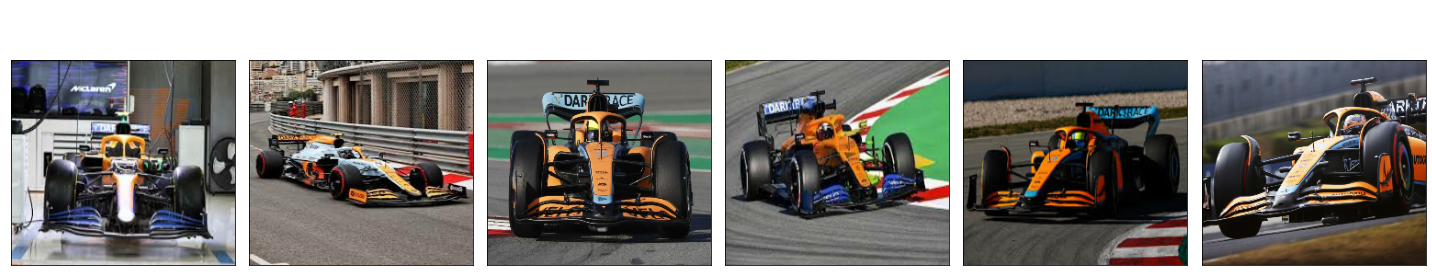

In [34]:
plot_random_image(train_dir)

## <span id='conv-to-ds'  style='font-weight:bold;color:white'> 7.Converting Data to ImageDatasets <hr></span>

In [35]:
IMAGE_SIZE=(224,224)

# tf.keras.preprocessing.image_dataset_from_directory
# turns image files sorted into class-specific folders into a labelded dataset of image tensors

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

class_names=train_data.class_names

# prefetching the datasets for faster training
train_data=train_data.prefetch(tf.data.AUTOTUNE)
test_data=test_data.prefetch(tf.data.AUTOTUNE)

Found 1934 files belonging to 8 classes.
Found 487 files belonging to 8 classes.


## <span id='m0'  style='font-weight:bold;color:white'> 8.model_V1</span>
<h5>- Using efficientnetB0 for feature extraction and training the model for 20% of the train data batches.</h5><hr>

## <span id='m0-build'  style='font-weight:bold;color:red'> 8.1.Building the model</span><hr>

In [36]:
mixed_precision.set_global_policy('mixed_float16')
inputs=layers.Input(shape=(224,224,3),name='input_layer')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [37]:
tf.keras.applications.EfficientNetB0()

TypeError: Exception encountered when calling layer "tf.math.truediv" (type TFOpLambda).

`x` and `y` must have the same dtype, got tf.float16 != tf.float32.

Call arguments received by layer "tf.math.truediv" (type TFOpLambda):
  • x=tf.Tensor(shape=(None, 224, 224, 3), dtype=float16)
  • y=tf.Tensor(shape=(3,), dtype=float32)
  • name=None